# LTAT.01.002 Keeletehnoloogia (2021 kevad)
# Kodutöö nr 2. Tekstide liigitamine
Töölehe struktuuri muuta ei tohi, lisada ei tohi uusi plokke ega eemaldada praeguseid (vajalikud plokkide ID-d on paigas). Plokid, mida muuta pole lubatud (vastav märge ploki alguses), kirjutatakse hindamisel üle. 

In [ ]:
# Colabi jaoks 
!pip install estnltk==1.6.7b

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/')

In [3]:
# Vajadusel kasutada üleslaetud failide lahtipakkimiseks
# Failide lahtipakkimine
#!unzip a_test.zip
#!unzip a_train.zip

In [3]:
import random
import os
import pandas as pd

In [4]:
# SEDA PLOKKI MUUTA EI TOHI!
labels = ["www.advent.ee", "www.bioneer.ee", "www.lapsemure.ee", "www.naisteleht.ee", "arvamus.postimees.ee"]

# Korpuse sisselugemine (korpus asub programmifaili kausta alamkaustas)
def loaddata(corpus):
	columns = ['label', 'text']
	data = pd.DataFrame(columns = columns)
	for f in os.listdir(os.getcwd() + "/" + corpus):
		df = pd.read_csv(os.getcwd() + "/" + corpus + "/" + f, delimiter="\t", index_col=None, header=None, names=columns)
		data = data.append(df)
	data = data.reset_index(drop=True)
	return data

# Hindamine (testhulgal)
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja testkorpuses olev info DataFrame'ina
def evaluate(model, testset):
	correct = 0
	for i, row in testset.iterrows():
		rightAnswer = row['label']
		text = row['text']
		prediction = predict(model, text)
		#print(rightAnswer, prediction)
		if rightAnswer == prediction:
			correct += 1
	print("Täpsus: {0:}%".format(100.0 * correct/len(testset)))
    
# Treenimine ja testimine
def train_and_test():
    # Loeme sisse treeningandmed ja teisendame need DataFrame'i kujule
    trainset = loaddata("a_train")
    # Loeme sisse testandmed ja teisendame need DataFrame'i kujule
    testset = loaddata("a_test")
    # Treenime mudelit
    model = learn(trainset)
    # Hindame tulemusi testhulgal
    evaluate(model, testset)

## Mudel 1: Bag-of-words sõnade põhjal

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
from sklearn import metrics
#Kasutan esimeses kolmes mudelis tfidftransformerit ja countvectorizerit
#globaalsete muutujatena, kuna predict funktsioonis on vaja sample peal
#kasutada juba fititud versioone, mis kaoksid vastasel juhul learn funktsiooni
#lõppedes ära. Lisaks sellele kirjutame need igas plokis niikuinii üle, niiet 
#anomaaliad peaksid olema välistatud kui töölehte ülevalt alla jooksutada. :)
tfidf_transformer = TfidfTransformer()
count_vect = CountVectorizer()
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada 
'''Praktikumi näidete najal loodud esimene Bag-of-words mudel'''
def learn(trainset):
    #count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(trainset["text"])
    #tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    # Siia tuleb kirjutada kood, mis loob ja tagastab mudeli
    model = MultinomialNB().fit(X_train_tfidf, trainset["label"])
    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    #Panen sample listi, kuna ennustamiseks on vaja iterable tüüpi objekti
    sample = [sample]
    sample_counts = count_vect.transform(sample)
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    return model.predict(sample_tfidf)

In [5]:
# SEDA PLOKKI MUUTA EI TOHI!
import time
start_time = time.time()
train_and_test()
print("--- %s seconds ---" % (time.time() - start_time))

Täpsus: 60.666666666666664%
--- 36.03142261505127 seconds ---


## Mudel 2: Bag-of-words lemmade põhjal (stopp-sõnadega arvestamata)

In [6]:
import estnltk
from estnltk import Text
tfidf_transformer = TfidfTransformer()
count_vect = CountVectorizer()
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada 
'''Muidu täpselt sama mudel mis esimene, ainult learn funktsioonis lemmatiseerime tekstid'''
def learn(trainset):
    #Lemmatiseerime
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in
                       [Text(tekst).tag_layer().words.lemma for tekst in trainset["text"]]]
    X_train_counts = count_vect.fit_transform(lemmatiseeritud)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    model = MultinomialNB().fit(X_train_tfidf, trainset["label"])
    return model
# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    sample = [sample]
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in
                      [Text(tekst).tag_layer().words.lemma for tekst in sample]]
    sample_counts = count_vect.transform(lemmatiseeritud)
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    return model.predict(sample_tfidf)

In [7]:
# SEDA PLOKKI MUUTA EI TOHI!
import time
start_time = time.time()
train_and_test()
print("--- %s seconds ---" % (time.time() - start_time))

Täpsus: 58.333333333333336%
--- 1005.9946444034576 seconds ---


## Mudel 3: Bag-of-words lemmade põhjal (stopp-sõnadega arvestades)

In [8]:
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
'''Muidu täpselt sama mudel mis 2. mudel, aga loome alguses stoppsõnade listi sagedussõnastiku
faili põhjal, võttes sealt esimesed 1750 sõna (nii saavutasin 80%lise täpsuse, edasine oleks
ilmselt juba overfitting).'''
#Stoppsõnade listi sisse lugemine
stopwords = []
with open("sagedussonastik_lemmad_kahanev.txt", 'r', encoding="UTF-8") as f:
    c = 0
    for line in f:
        if c >= 1750:
            break
        stopwords.append(line.split()[1])
        c+=1

#Loome countvectorizeri stoppsõnadega
count_vect = CountVectorizer(stop_words=stopwords)
tfidf_transformer = TfidfTransformer()

def learn(trainset):
    #Lemmatiseerimine
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in
                       [Text(tekst).tag_layer().words.lemma for tekst in trainset["text"]]]
    X_train_counts = count_vect.fit_transform(lemmatiseeritud)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    model = MultinomialNB().fit(X_train_tfidf, trainset["label"])
    return model

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    sample = [sample]
    lemmatiseeritud = [" ".join([lemma[0] for lemma in tekst]) for tekst in
                      [Text(tekst).tag_layer().words.lemma for tekst in sample]]
    sample_counts = count_vect.transform(lemmatiseeritud)
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    return model.predict(sample_tfidf)

In [9]:
# SEDA PLOKKI MUUTA EI TOHI!
import time
start_time = time.time()
train_and_test()
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Joosep\anaconda3\envs\Keeletehnoloogia\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ajalt', 'olla', 'võib'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Täpsus: 80.33333333333333%
--- 985.4481749534607 seconds ---


## Mudel 4: Word2Veci abil

In [128]:
'''MUDELI LOOMISEL LEIDSIN ABI:
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/'''
import gensim
import nltk
'https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html'
from sklearn.pipeline import Pipeline
'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html'
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada
def learn(trainset):
    #Tokeniseerime teksti nltk abil, kuna gensimi mudel tahab tokeniseeritud tekste
    tokenized = [nltk.word_tokenize(tekst) for tekst in trainset["text"]]
    #Treenime word2vec mudeli nullist kasutades gensimi
    model = gensim.models.Word2Vec(tokenized, size=100)
    #Loome sõnastiku, mis sisaldab endas sõna->100-dimensiooniline vektor.
    #Selle najal saame leida keskmisi sõnavektoreid iga sõna kohta tekstis.
    w2v = dict(zip(model.wv.index2word, model.wv.syn0))
    #Nüüd saame defineerida tagastatava mudeli, mis võtab argumendiks tokeniseeritud
    #teksti, vektoriseerib ja õpib vektoreid klassifitseerima vabalt valitud klassifitseerijaga
    #Siinkohal ExtraTreesClassifier
    etreeModel = Pipeline([
        ("word2vec vectorizer", CountVectorizer(w2v)),
        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
    etreeModel.fit(trainset["text"], trainset["label"])
    return etreeModel

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    return model.predict([sample])[0]


In [129]:
# SEDA PLOKKI MUUTA EI TOHI!
import time
start_time = time.time()
train_and_test()
print("--- %s seconds ---" % (time.time() - start_time))

INFO:word2vec.py:1588: collecting all words and their counts
INFO:word2vec.py:1573: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:word2vec.py:1596: collected 200972 word types from a corpus of 1813042 raw words and 3963 sentences
INFO:word2vec.py:1647: Loading a fresh vocabulary
INFO:word2vec.py:1671: effective_min_count=5 retains 30080 unique words (14% of original 200972, drops 170892)
INFO:word2vec.py:1677: effective_min_count=5 leaves 1568625 word corpus (86% of original 1813042, drops 244417)
INFO:word2vec.py:1736: deleting the raw counts dictionary of 200972 items
INFO:word2vec.py:1739: sample=0.001 downsamples 30 most-common words
INFO:word2vec.py:1742: downsampling leaves estimated 1234996 word corpus (78.7% of prior 1568625)
INFO:base_any2vec.py:1022: estimated required memory for 30080 words and 100 dimensions: 39104000 bytes
INFO:word2vec.py:1888: resetting layer weights
INFO:base_any2vec.py:1210: training model with 3 workers on 30080 vocabulary and

C:\Users\Joosep\anaconda3\envs\Keeletehnoloogia\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Täpsus: 90.0%
--- 131.83951783180237 seconds ---


## Mudel 5: parima täpsusega mudel
Siia looge parim mudel, mis õnnestus saada käesoleva kodutöö puhul

In [15]:
'''MUDELI LOOMISEL LEIDSIN ABI:
http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/'''
import gensim
import nltk
'https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html'
from sklearn.pipeline import Pipeline
'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html'
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Treenimine
# Sisend: treeningkorpuses olev info DataFrame'ina
# Väljund: mudel, millega suudab ennustamisfunktsioon hakkama saada 
'''Täpselt sama mudel, mis neljas Word2Vec, aga CountVectorizeris kasutame ka stoppsõnu
Katse-eksituse meetodil tundus, et vähemate stoppsõnade kasutamine siin on edukam kui
rohkemate. Seega otsustasin võtta failist ainult top15 lemmatiseeritud sõna. Kuna tegemist on
põhiliselt ase- ja sidesõnadega, siis kõigi tekstide tervenisti lemmatiseerimine meile midagi
juurde ei anna. Lisaks asendasin siin CountVectorizeri TfidfVectorizeriga, kuna see täidab nii
countvectorizeri kui tfidftransformeri funktsiooni.
'''
stopwords = []
with open("sagedussonastik_lemmad_kahanev.txt", 'r', encoding="UTF-8") as f:
    c = 0
    for line in f:
        if c >= 1000:
            break
        stopwords.append(line.split()[1])
        c+=1

def learn(trainset):
    documents = [TaggedDocument(tekst, [i]) for i, tekst in enumerate(trainset["text"])]
    model = Doc2Vec(documents, vector_size=200)
    d2v = dict(zip(model.wv.index2word, model.wv.syn0))
    etreeModel = Pipeline([
        # Siin kasutan hoopis TfidfVectorizerit
        ("wdoc2vec vectorizer", TfidfVectorizer(d2v, stop_words=stopwords)),
        ("extra trees", ExtraTreesClassifier(n_estimators=200))])
    etreeModel.fit(trainset["text"], trainset["label"])
    return etreeModel

# Ennustamine
# Sisend: treenimisfunktsiooni väljundist saadud mudel ja tekstinäide, mida peab liigitama
# Väljund: üks element järjendist "labels"
def predict(model, sample):
    return model.predict([sample])[0]


In [16]:
# SEDA PLOKKI MUUTA EI TOHI!
import time
start_time = time.time()
train_and_test()
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\Joosep\anaconda3\envs\Keeletehnoloogia\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
C:\Users\Joosep\anaconda3\envs\Keeletehnoloogia\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass input={' ': array([ 5.78656718e-02,  2.52324820e-01,  2.16842502e-01,  2.55964339e-01,
       -3.23823005e-01,  6.82488224e-03, -3.95684332e-01, -3.29813026e-02,
       -3.51825327e-01,  1.98323280e-01,  1.11104891e-01,  2.71562219e-01,
       -2.48400137e-01,  9.17537883e-02,  1.81588426e-01,  2.60379493e-01,
       -5.95662296e-01,  1.17633544e-01,  1.96506441e-01,  9.59886014e-02,
        2.15833530e-01, -3.25639427e-01, -1.23349875e-01,  9.78243575e-02,
        1.54135242e-01,  1.48249000e-01, -2.07191229e-01, -1.00470282e-01,
       -2.73203373e-01, -2.06633583e-01, -5.71089536e-02,  4.09781784e-02,
        3.06560881e-02,  1.25982016e-01,  2.74506152e-01, -1.2055014

Täpsus: 89.33333333333333%
--- 98.7361512184143 seconds ---


## Analüüs ja diagramm


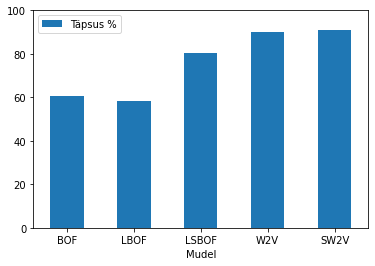

In [195]:
# Arusaadav(ad) ja mõistlik(ud) diagramm(id), millel on võrreldud kõiki loodud mudeleid
'''
Lühendite legend:
    BOF -> Bag Of Words
    LBOF -> Lemmatiseerimisega Bag Of Words
    LSBOF -> Lemmatiseerimise ja stoppsõnadega Bag Of Words
    W2V -> Gensim ja sklearn najal ehitatud Word2Vec
    SW2V -> Sama Word2Vec, aga stoppsõnadega
'''
# Täpsused on hardcoded, kuna train_and_test() plokid kirjutatakse väidetavalt hindamisel üle
# Word2Vec mudelid ei ole täielikult deterministlikud, seega võib nende täpsus 1-2% võrra 
# taaskäivitamisel varieeruda.
df = pd.DataFrame({'Mudel':['BOF', 'LBOF', 'LSBOF', 'W2V', 'SW2V'], 
                   'Täpsus %':[60.666666666666664, 58.333333333333336, 80.33333333333333, 90.0, 91.0]})
ax = df.plot.bar(x='Mudel', y='Täpsus %', rot=0).set_ylim(0, 100)

<b>Analüüs ja kokkuvõte: </b>
<br>
    Bag Of Words mudel on ligi 60.67%-lise täpsusega juba tunduvalt parem kui juhuslik liigitamine,
    Lemmatiseeritud Bag Of Words ei tundu tulemust parandavat (ca 58.3%), ilmselt sellepärast, et ainult
    lemmatiseerimisega muudame tekstid pigem sarnasemaks kui eristatavamaks. Lemmatiseeritud
    Bag Of Words tihedalt esinevate sõnade ignoreerimisega stoppsõnade abil, aga on väga edukas,
    ning saavutab 80.33%-lise täpsuse, mida saaks võib-olla veel täpsemaks kasutades rohkem
    stoppsõnu, kuid siis võime juba mudeli overfittida. Word2Vec sklearni Pipeline ja ExtraTreesClassifieriga on vaieldamatult parem kui eelmised proovitud mudelid, saavutades 90.0% täpsuse. Nüüd proovides kõiki mudeleid kõige täpsema mudeli saamiseks ühendada, avastasin, et lemmatiseerimine ei aidanud Word2Vec meetodi tulemust üldse parandada ja kasvatas tööaega ligi
    9 korda suuremaks, otsustasin selle välja jätta. Stoppsõnade kasutamine ja TfidfVectorizeri sisse toomine, aga muutis täpsust
    1% võrra paremaks. Sellest tulenevalt saavutasingi oma parima mudeli -> Stoppsõnadega 
    Word2Vec 91.0%-lise täpsusega. </br>
<br><b>Autor: Joosep Tavits B96890</b></br>

## Arvamus käesoleva koduse töö kohta (vabatahtlik)
Negatiivse arvamuse eest ei saa vähem punkte ;)

Väga huvitav kodutöö, kui esimese mudeli tööle sain, läks nagu lepase reega ja nautisin protsessi. Ainus asi mis tekitas pahameelt, ja seda üsna mahukalt, oli asjaolu, et lemmatiseerimist estnltk abil on meilt otseselt eeldatud ja selle kasutamine mistahes mudeli loomisel pikendab tööaega 9 kuni peaaegu 30 korda sõltuvalt mudelist. Lemmatiseerimise järel ootamisele aega kulutamata oleks kodutöö ilmselt 3-4 tundi aega võtnud, aga tänu inimlikele vigadele ja mallprogrammiga kaasa tulevatele indentationErroritele, mis muidugi avastati peale lemmatiseerimist, sai kulutatud peaaegu 12 tundi. Tekib mõte, et kursuse alguses antud hoiatus, et kodutöid ei saa valmis teha eelneval õhtul ega isegi eelneva kahe päeva jooksul peab vett ainult kodutöödes kus tuleb kasutada mingit estnltk osa, mis on igasuguse suure sisendi korral MEELETULT aeglane. Oleks mõistlik järgmine kord mallprogrammi üles laadides jälgida, et sellega poleks kaasa antud 5 korda korratud indentationErrorit, ning kuigi mõistan, et kuidagi muud moodi kui estnltk-ga neid tekste väga lemmatiseerida ei anna, võiks ikkagi tõsiselt kaaluda estnltk kasutamise nõudmist kodutöödes, kuna sisuliselt puhtalt selle järel ootamine pikendab kodutöö protsessi peaaegu 3 korda. Sellest kõigest hoolimata, oli tõesti põnev kodutöö teema, aine hakkab isegi vaikselt meeldima. 

Lugupidamisega
<br>Joosep Tavits</br>